<img align=left src="CRIkit_Logo.png"> 
<br>
<br>
<br>
<br>
<br>
#####Coherent Raman Imaging toolKit

# A Quick and Simple Demonstration


###Setup

In [1]:
# Setup our imports

%pylab inline

import sys
import time
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt


import als_methods as als
import pre as crikit

Populating the interactive namespace from numpy and matplotlib
No pyFFTW found. Using Scipy instead. 
    You may want to install pyFFTW and FFTW for [potentially]
    significant performance enhancement


###Simulate a CARS Signal

In this extremely simplied example:<br>
<ul>
<li>$I_{CARS}(\omega) = \left | \chi_R(\omega) + \chi_{NR}(\omega) \right |^2$
<li>$I_{NRB}(\omega) = \left | \chi_{NR}(\omega) \right |^2$
<li>$I_{REF}(\omega) = \left | \chi_{REF}(\omega) \right |^2$
</ul>

The NRB is the **actual** background and the **reference [NRB]** is a close-but-not-the-same measurement.

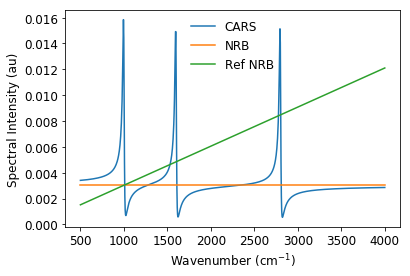

In [3]:
# Create CARS, NRB, and NRB reference signals

SPECT_LEN = 878
WN = np.linspace(500, 4000, SPECT_LEN)
WN = WN[:,np.newaxis]

AMP = (1, 1, 1)
OMEGA = (1000, 1600, 2800)
GAMMA = (10, 10, 10)

CHI = np.array(np.zeros(WN.shape),dtype=complex)
CHI_R = np.array(np.zeros(WN.shape),dtype=complex)
CHI_NR = np.array(0.055*np.ones(WN.shape),dtype=complex)
CHI_REF = CHI_NR*(WN/1e3)**.5

for count in range(len(AMP)):
    CHI_R += AMP[count]/(OMEGA[count] - WN - 1j*GAMMA[count])

CHI = CHI_NR + CHI_R

I_CARS = np.abs(CHI)**2
I_NRB = np.abs(CHI_NR)**2
I_REF = np.abs(CHI_REF)**2

plt.rc('font',size=12)
plt.plot(WN, I_CARS, label = 'CARS')
plt.plot(WN, I_NRB, label = 'NRB')
plt.plot(WN, I_REF, label = 'Ref NRB')

plt.legend(loc=0,frameon = False)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Spectral Intensity (au)')
plt.show()

### Perform the Kramers-Kronig Relation to Extract the Spectral Phase

####References:

Y. Liu, Y. J. Lee, and M. T. Cicerone, "Broadband CARS spectral phase retrieval using a time-domain Kramers-Kronig transform," Opt. Lett. 34, 1363-1365 (2009).

C. H. Camp Jr, Y. J. Lee, and M. T. Cicerone, "Quantitative, comparable coherent anti-Stokes Raman scattering (CARS) spectroscopy: Correcting errors in phase retrieval" (2015). arXiv:1507.06543.


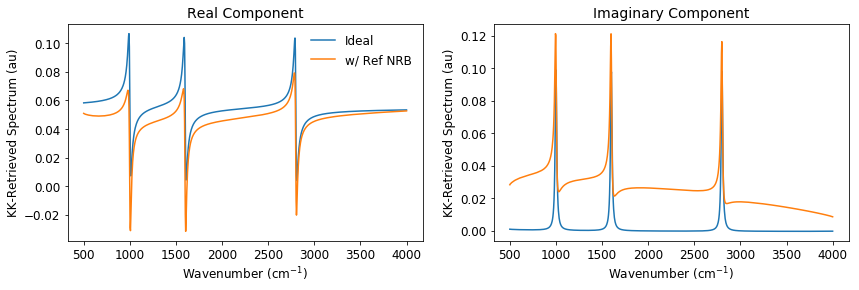

In [4]:
PHASE_OFFSET = 0 # DC phase-offset (default = 0)
NORM_BY_NRB = 1 # Normalize retrieved spectrum by NRB/REF-- Removes the optical system response (default = 1)


# Perform the Kramers-Kronig Relationship when the NRB is known (ideal case)
Retrieved_complex_spectrum_ideal = crikit.kkrelation(I_NRB,I_CARS,PHASE_OFFSET,NORM_BY_NRB) # Complex spectrum
Retrieved_Raman_spectrum_ideal = Retrieved_complex_spectrum_ideal.imag # "Raman-like# (imag{complex spectrum})

# Perform the Kramers-Kronig Relationship when using a surrogate NRB "reference"
Retrieved_complex_spectrum_w_reference = crikit.kkrelation(I_REF,I_CARS,PHASE_OFFSET,NORM_BY_NRB) # Complex spectrum
Retrieved_Raman_spectrum_w_reference = Retrieved_complex_spectrum_w_reference.imag # "Raman-like# (imag{complex spectrum})

plt.figure(figsize=[14, 4])
plt.rc('font',size=12)
plt.subplot(121)

plt.plot(WN, Retrieved_complex_spectrum_ideal.real, label = 'Ideal')
plt.plot(WN, Retrieved_complex_spectrum_w_reference.real, label = 'w/ Ref NRB')

plt.legend(loc=0,frameon = False)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('KK-Retrieved Spectrum (au)')
plt.title('Real Component', fontsize=14)

plt.subplot(122)
plt.plot(WN, Retrieved_complex_spectrum_ideal.imag, label = 'Ideal (Imag)')
plt.plot(WN, Retrieved_complex_spectrum_w_reference.imag, label = 'w/ Ref NRB (Imag)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('KK-Retrieved Spectrum (au)')
plt.title('Imaginary Component', fontsize=14)
plt.show()

### Phase-Detrending Using Asymmetric Least Square (ALS)

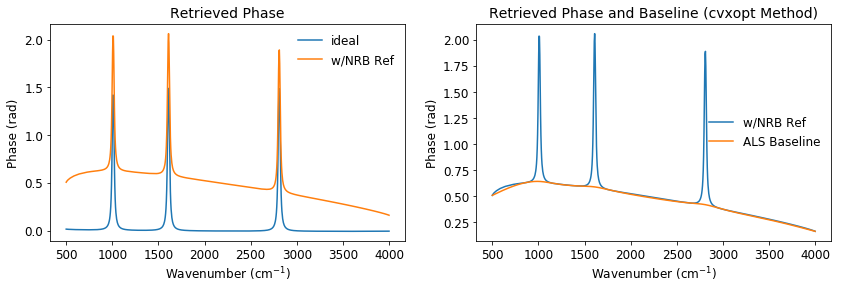

In [6]:
# ALS takes two parameters-- their ratio is the most important
SMOOTHNESS_PARAM = 1e3
ASYM_PARAM = 1e-4

plt.figure(figsize=[14, 4])
plt.rc('font',size=12)

plt.subplot(121)
plt.plot(WN, np.angle(Retrieved_complex_spectrum_ideal),label = 'ideal')
plt.plot(WN, np.angle(Retrieved_complex_spectrum_w_reference), label = 'w/NRB Ref')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Phase (rad)')
plt.title('Retrieved Phase', fontsize = 14)
legend(loc = 0, frameon = False)

# Find baseline with optimal als method (see CRIkit.utils.als_methods for more info)
[Baseline, als_method] = als.als_baseline(np.angle(Retrieved_complex_spectrum_w_reference), SMOOTHNESS_PARAM, \
                                             ASYM_PARAM)
plt.subplot(122)
plt.plot(WN, np.angle(Retrieved_complex_spectrum_w_reference), label = 'w/NRB Ref')
plt.plot(WN, Baseline, label = 'ALS Baseline')

plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Phase (rad)')
plt.title('Retrieved Phase and Baseline (' + als_method + ' Method)', fontsize = 14)
plt.legend(frameon = False)

###Correcting for Phase and Amplitude Error

In [5]:
# Error phase (baseline) and amplitude connected via Kramers-Kronig relation (Hilbert transform)
Error_phase = Baseline
Error_amp = np.exp(crikit.hilbertfft(Error_phase).imag)
Correction_factor_1 = 1/Error_amp * np.exp(-1j*Error_phase)

Phase_Corrected = Retrieved_complex_spectrum_w_reference*Correction_factor_1

# Amiguity in phase-amp correction found by looking at mean-trend line of real componenet
# Using low-order, large-window Savitky-Golay
SGOLAY_WINDOW = 601
SGOLAY_POLY_ORDER = 2

Scaling_factor = 1/(scipy.signal.savgol_filter(np.real(Phase_Corrected),SGOLAY_WINDOW,SGOLAY_POLY_ORDER,axis=0))

Corrected = Scaling_factor*Phase_Corrected

# Compare these results with traditional baseline detrending of the Raman-like spectrum retrieved
# directly from the Kramers-Kronig relation
Just_amplitude_corrected = Retrieved_Raman_spectrum_w_reference - als.als_baseline(Retrieved_Raman_spectrum_w_reference,1e3,1e-4)[0]

plt.figure(figsize=[14, 4])
plt.rc('font',size=12)
plt.plot(WN,Corrected.imag, label='Phase Corrected + Scaling')
plt.plot(WN,Just_amplitude_corrected, label = 'Baseline Detrended (only)')
plt.plot(WN,CHI_R.imag/np.abs(CHI_NR), 'r--', label = 'Ideal')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Corrected Raman-Like Spectrum', fontsize = 14)
plt.legend(frameon = False)

NameError: name 'Baseline' is not defined

##Phase Detrending and Scaling (i.e., Full Correction) in 3 line

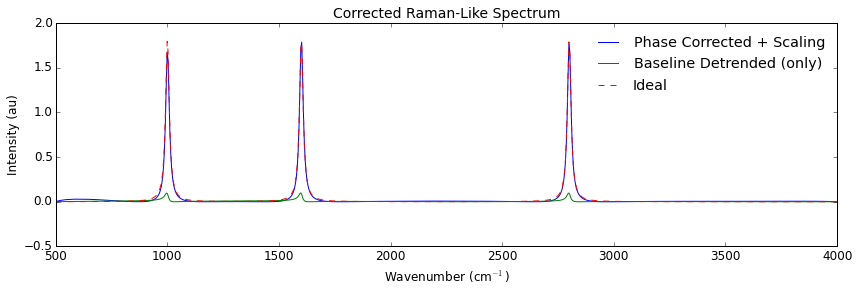

In [13]:
"""
These are defined earlier:
SMOOTHNESS_PARAM
ASYM_PARAM
SGOLAY_WINDOW
SGOLAY_POLY_ORDER
"""
# Starts here
Error_phase = als.als_baseline(np.angle(Retrieved_complex_spectrum_w_reference), SMOOTHNESS_PARAM,ASYM_PARAM)[0]
Phase_Corrected = Retrieved_complex_spectrum_w_reference*(1/np.exp(crikit.hilbertfft(Error_phase).imag) * \
                                                          np.exp(-1j*Error_phase))
Corrected = 1/(scipy.signal.savgol_filter(np.real(Phase_Corrected),601,2,axis=0))*Phase_Corrected
# Done

Just_amplitude_corrected = Retrieved_Raman_spectrum_w_reference - \
    als.als_baseline(Retrieved_Raman_spectrum_w_reference,1e3,1e-4)[0]

plt.figure(figsize=[14, 4])
plt.rc('font',size=12)
plt.plot(WN,Corrected.imag, label='Phase Corrected + Scaling')
plt.plot(WN,Just_amplitude_corrected, label = 'Baseline Detrended (only)')
plt.plot(WN,CHI_R.imag/np.abs(CHI_NR), 'r--', label = 'Ideal')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Corrected Raman-Like Spectrum', fontsize = 14)
plt.legend(frameon = False)